In [22]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import os

root = Path(os.getcwd()).parent
sys.path.append(root)

from configs.load_model_and_config import load_yaml_training_config
from classification.train import get_output_dir_from_config
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from matplotlib.ticker import FormatStrFormatter

In [23]:
abbreviation_dict = {
    "MC-dropout-S": "MC-S",
    "MC-dropout-E": "MC-E",
    "Baseline": "Base",
    "Laplace": "L",
    "TrustScore": "TS",
    "ConfidNet": "CN",
    "Ensemble": "Ens",
    "SWAG": "SWAG",
    "DUQ": "DUQ",
    "DoctorAlpha": r"$D_{\alpha}$",
}

my_colors = {
    "Base": "b",
    "TS": "darkorange",
    "MC-S": "g",
    "MC-E": "r",
    "L": "mediumvioletred",
    "CN": "darkgoldenrod",
    "DUQ": "grey",
    "SWAG": "lightseagreen",
    r"$D_{\alpha}$": "lightgreen",
    "Ens": "black",
}


def get_all_metrics_df_from_config(config):
    seeds = config.seed
    all_dfs = []
    for seed in seeds:
        config.seed = seed
        output_folder = Path(root) / get_output_dir_from_config(config)
        df_experiment = pd.read_csv(
            output_folder / "failure_detection" / "all_metrics.csv"
        )
        df_experiment["seed"] = seed
        all_dfs.append(df_experiment)
    ensemble_df = pd.read_csv(
        output_folder.parent / "failure_detection" / "ensemble_metrics.csv"
    )
    all_dfs.append(ensemble_df)
    dfs_aggregated = pd.concat(all_dfs)
    dfs_aggregated.loc[
        dfs_aggregated["Scorer"] == "MCMC Average Softmax score - Agg pred", "Scorer"
    ] = "MC-dropout-S"
    if config.n_classes > 2:
        dfs_aggregated.loc[
            dfs_aggregated["Scorer"] == "MCMC Entropy score - Agg pred", "Scorer"
        ] = "MC-dropout-E"
    dfs_aggregated.loc[
        dfs_aggregated["Scorer"] == "Ensemble aggregated soft", "Scorer"
    ] = "Ensemble"
    dfs_aggregated.loc[
        dfs_aggregated["Scorer"] == "Trust Score", "Scorer"
    ] = "TrustScore"
    config.seed = seeds
    return dfs_aggregated

In [24]:
scores_full = [
    "Baseline",
    "DoctorAlpha",
    "TrustScore",
    "MC-dropout-E",
    "MC-dropout-S",
    "Laplace",
    "SWAG",
    "ConfidNet",
    "DUQ",
    "Ensemble",
]

scores_for_ablation = [
    "Baseline",
    "DoctorAlpha",
    "TrustScore",
    "MC-dropout-E",
    "MC-dropout-S",
    "Laplace",
    "Ensemble",
]


def get_error_detection_boxplot(dfs_metrics, ax, scores_to_plot=scores_full):
    df_plot = dfs_metrics.loc[dfs_metrics["Scorer"].isin(scores_to_plot)]
    df_plot["Scorer"] = df_plot["Scorer"].apply(lambda x: abbreviation_dict[str(x)])
    sns.boxplot(
        x="Scorer",
        y="ROC_AUC_error_detection_global",
        data=df_plot,
        whis=np.inf,
        ax=ax,
        palette=my_colors,
    )
    ax.set_xlabel("")
    ax.tick_params(labelsize=18)
    ax.set_ylabel(
        "ROC-AUC Error Detection",
        fontdict={"fontsize": 20},
    )


def get_fpr95_boxplot(dfs_metrics, ax):
    df_plot = dfs_metrics.loc[dfs_metrics["Scorer"].isin(scores_full)]
    df_plot["Scorer"] = df_plot["Scorer"].apply(lambda x: abbreviation_dict[str(x)])
    sns.boxplot(
        x="Scorer", y="FPR_TPR80", data=df_plot, whis=np.inf, ax=ax, palette=my_colors
    )
    ax.set_xlabel("")
    ax.set_ylabel("FPR@80TPR", fontdict={"fontsize": 20})
    ax.tick_params(labelsize=18)

In [25]:
all_configs = [
    # "EyePACS/retino_resnet.yml",
    # "medmnist/organamnist_resnet_dropout_all_layers.yml",
    # "medmnist/pathmnist_resnet_dropout_all_layers.yml",
    # "medmnist/tissuemnist_resnet_dropout_all_layers.yml",
    # "rsna/rsna_resnet50_dropout_all_layers.yml",
    "busi/busi_resnet.yml",
]
for i, config_name in enumerate(all_configs):
    config = load_yaml_training_config(Path(root) / "configs" / config_name)
    dfs_metrics = get_all_metrics_df_from_config(config)
    sns.set_theme(style="darkgrid", palette="colorblind")
    sns.set_color_codes()
    f, ax = plt.subplots(1, 2, figsize=(25, 6))
    get_error_detection_boxplot(dfs_metrics, ax[0])
    get_fpr95_boxplot(dfs_metrics, ax[1])
    ax[0].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    title = config.dataset if config.dataset != "DiabeticRetino" else "EyePACS"
    plt.suptitle(r"$\bf{}$".format(title), fontsize=28)
    if not os.path.exists(str(Path(root) / "outputs" / "figures")):
        os.makedirs(str(Path(root) / "outputs" / "figures"))
    plt.savefig(
        format="pdf",
        fname=str(Path(root) / "outputs" / "figures" / f"full_{config.dataset}.pdf"),
        bbox_inches="tight",
    )
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Computer_Vision\\Medical_Images_With_Rejection\\failure_detection_benchmark\\outputs\\BUSI\\resnet18\\dropout_all_layers_autolr_longer\\failure_detection\\ensemble_metrics.csv'

# Plots for ablation study

In [26]:
def plot_ablation(list_configs):
    f, ax = plt.subplots(1, 3, figsize=(28, 6))
    sns.set_theme(style="darkgrid", palette="colorblind")
    sns.set_color_codes()
    pretty_model_names = {
        "resnet18": "ResNet-18",
        "resnet50": "ResNet-50",
        "wideresnet50": "WideResNet-50",
        "densenet": "DenseNet-121",
    }
    for i, config_name in enumerate(list_configs):
        config = load_yaml_training_config(Path(root) / "configs" / config_name)
        dfs_metrics = get_all_metrics_df_from_config(config)
        get_error_detection_boxplot(dfs_metrics, ax[i], scores_for_ablation)
        ax[i].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
        model_name = pretty_model_names[config.model_name]
        ax[i].set_title(f"Model: {model_name}", fontdict={"fontsize": 20})
        title = config.dataset if config.dataset != "DiabeticRetino" else "EyePACS"
    ax[0].set_ylabel(
        r"$\bf{}$".format(title) + "\n" + ax[0].get_ylabel(),
        fontdict={"fontsize": 20},
    )
    plt.savefig(
        format="pdf",
        fname=str(
            Path(root) / "outputs" / "figures" / f"model_ablation_{config.dataset}.pdf"
        ),
        bbox_inches="tight",
    )
    plt.show()

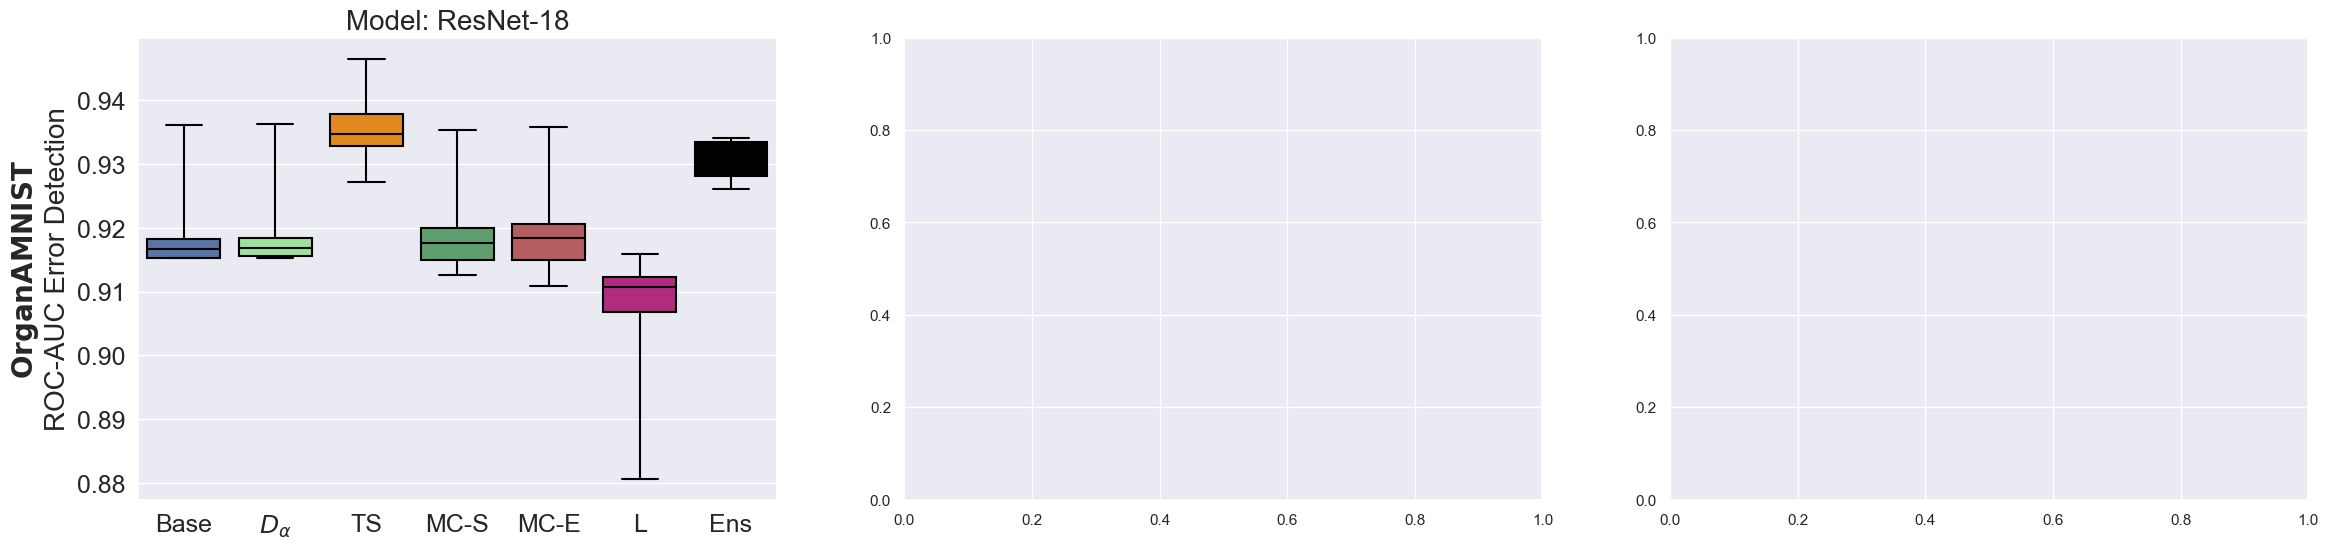

In [26]:
all_configs = [
    "medmnist/organamnist_resnet_dropout_all_layers.yml",
    # "medmnist/organamnist_densenet_dropout_all_layers.yml",
    # "medmnist/organamnist_wideresnet_dropout_all_layers.yml",
]
plot_ablation(all_configs)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Computer_Vision\\Medical_Images_With_Rejection\\failure_detection_benchmark\\outputs\\PathMNIST\\resnet18\\dropout_all_layers_autolr\\seed_11\\failure_detection\\all_metrics.csv'

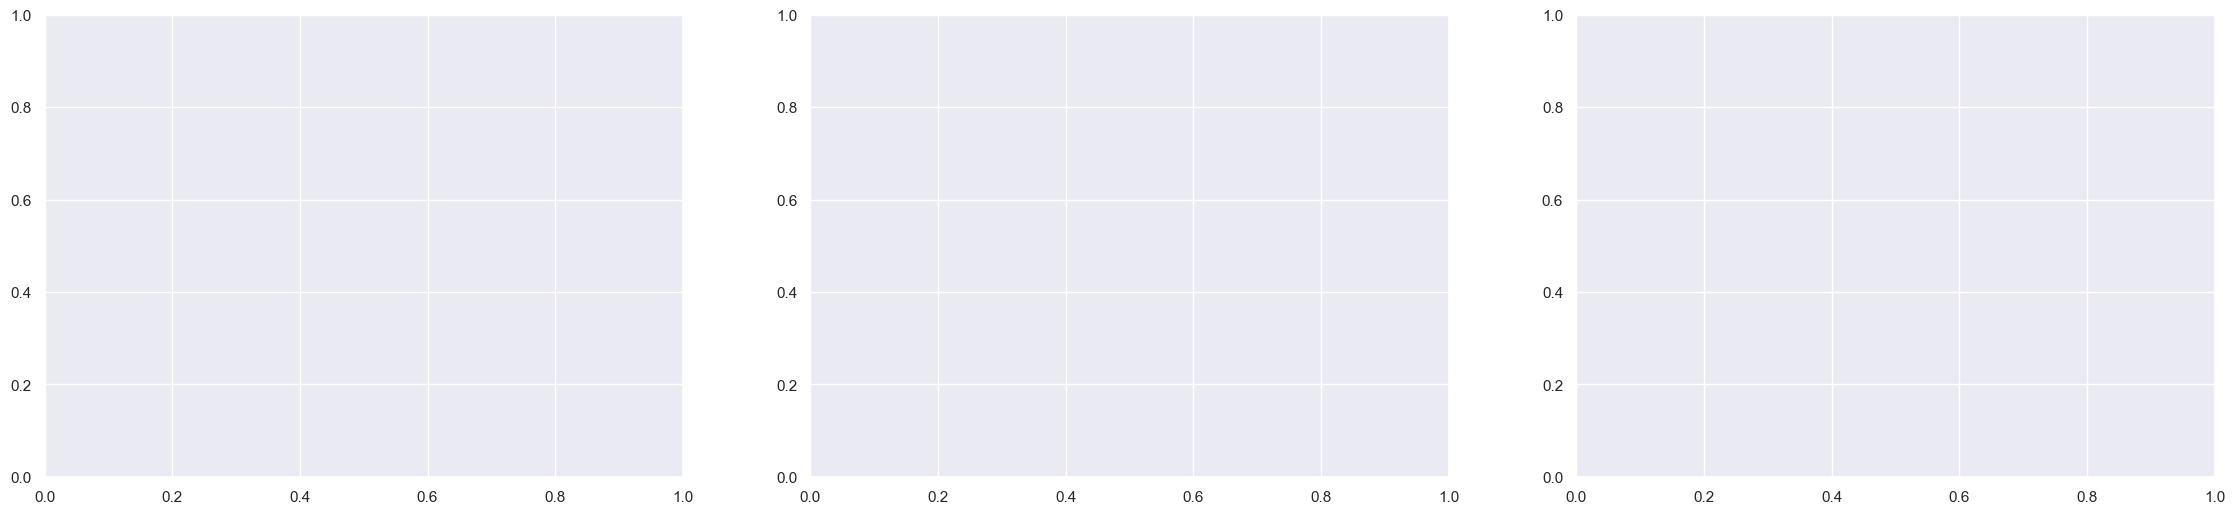

In [27]:
# all_configs = [
#     "medmnist/pathmnist_resnet_dropout_all_layers.yml",
#     "medmnist/pathmnist_densenet_dropout_all_layers.yml",
#     "medmnist/pathmnist_wideresnet_dropout_all_layers.yml",
# ]
# plot_ablation(all_configs)

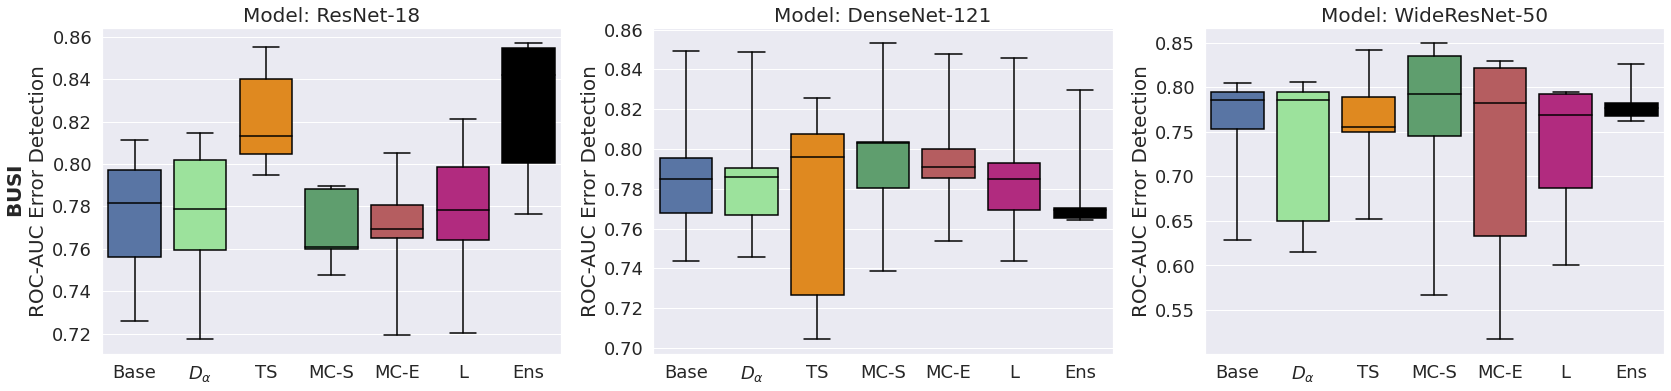

In [9]:
# all_configs = [
#     "busi/busi_resnet.yml",
#     "busi/busi_densenet.yml",
#     "busi/busi_wideresnet.yml",
# ]
# plot_ablation(all_configs)

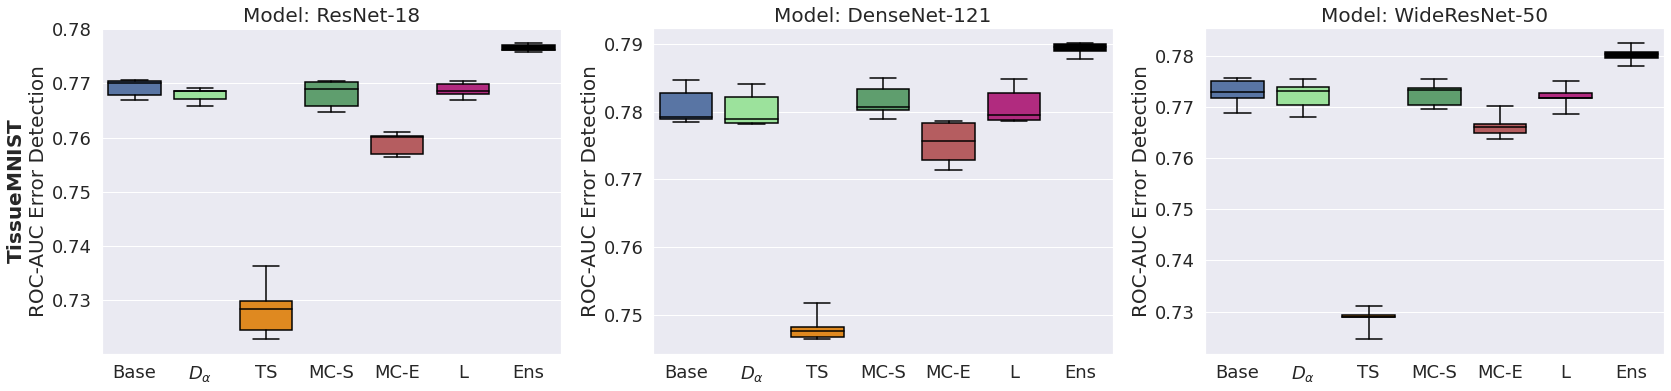

In [10]:
# all_configs = [
#     "medmnist/tissuemnist_resnet_dropout_all_layers.yml",
#     "medmnist/tissuemnist_densenet_dropout_all_layers.yml",
#     "medmnist/tissuemnist_wideresnet_dropout_all_layers.yml",
# ]
# plot_ablation(all_configs)

In [ ]:
# all_configs = [
#     "rsna/rsna_resnet50_dropout_all_layers.yml",
#     "rsna/rsna_densenet_dropout_all_layers.yml",
#     "rsna/rsna_wideresnet_dropout_all_layers.yml",
# ]
# plot_ablation(all_configs)

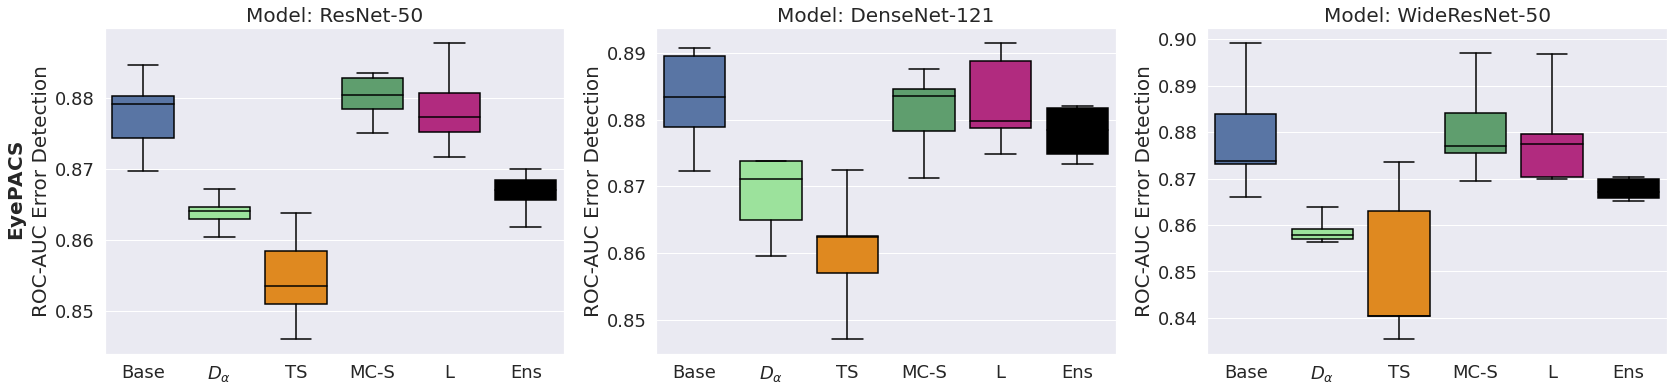

In [11]:
# all_configs = [
#     "EyePACS/retino_resnet.yml",
#     "EyePACS/retino_densenet.yml",
#     "EyePACS/retino_wideresnet.yml",
# ]
# plot_ablation(all_configs)